In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

## Wczytanie zbioru:

In [2]:
cars = pd.read_csv('cars.csv')

## Wyświetlenie pierwszych wierszów zbioru:

In [3]:
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


Na pierwszy rzut oka widać, że zbiór posiada brakujące wartości (w tym przypadku `?`) oraz zmienne kategoryczne, które będą wymagały skorzystania z metody `one-hot-encoding`.
<img src='https://miro.medium.com/max/1400/1*ggtP4a5YaRx6l09KQaYOnw.webp' width=500> 
W przypadku brakujących wartości należy przyjrzeć się mi bliżej aby określić co z nimi zrobić.

## Wyświetlenie informacji o zbiorze:

In [4]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

Kolumny, które zawierają zmienne kategoryczne lub przynajmniej jedną brakującą wartość - `?`, są rozpoznawne jako `object`.
Aby to zmienić, tam gdzie powinny być wartości liczbowe dokonam konwersji wszystkich wartości z kolumny na typ numerowy. W celu uniknięcia błędów użyję parametru `errors='coerce'`, który zamieni nieliczbowe wartości na `NaN`.

In [6]:
cars["normalized-losses"] = pd.to_numeric(cars["normalized-losses"], errors='coerce')
cars["bore"] = pd.to_numeric(cars["bore"], errors='coerce')
cars["stroke"] = pd.to_numeric(cars["stroke"], errors='coerce')
cars["horsepower"] = pd.to_numeric(cars["horsepower"], errors='coerce')
cars["peak-rpm"] = pd.to_numeric(cars["peak-rpm"], errors='coerce')
cars["price"] = pd.to_numeric(cars["price"], errors='coerce')
cars.head(2)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0


Jak widać `?` zostały zamienione na `NaN` w odpowiednich miejscach.

### Sprawdzenie ile NaN'ów jest w każdej z kolumn:

In [8]:
cars.isna().sum(axis=0)    # axis=0 - sprawdza po kolumnach

symboling             0
normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          0
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

Jak widzimy wartości `NaN` w kolumnie `normalized-losses` stanowią aż $1/5$ zbioru. Jest to zdecydowanie za dużo, więc postanowiłem całkowicie odrzucić tą kolumnę.
Postanowiłem również odrzucić 4 wartości z brakami w kolumnie `price` (która będzie zmienną objaśnianą).

In [9]:
cars.drop('normalized-losses', inplace=True, axis=1)
cars=cars.dropna(subset=['price'])

W przypadku pozostałych brakujących wartości postanowiłem zastąpić je średnią.

In [10]:
cars['bore'] = cars['bore'].fillna(cars['bore'].mean(skipna=True))
cars['stroke'] = cars['stroke'].fillna(cars['stroke'].mean(skipna=True)) 
cars['peak-rpm'] = cars['peak-rpm'].fillna(cars['peak-rpm'].mean(skipna=True))
cars['horsepower'] = cars['horsepower'].fillna(cars['horsepower'].mean(skipna=True)) 

### Sprawdzenie ile NaN'ów jest w poszczególnych wierszach

In [11]:
cars[cars.isna().any(axis=1)]

,symboling,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price


### Pozostałe brakujące wartości
Wśród wartości kategorycznych również znajdują się brakujące wartości którymi należy się zająć.

In [12]:
cars[cars['num-of-doors'] == '?']

,symboling,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
27,1,dodge,gas,turbo,?,sedan,fwd,front,93.7,157.3,...,98,mpfi,3.03,3.39,7.6,102.0,5500.0,24,30,8558.0
63,0,mazda,diesel,std,?,sedan,fwd,front,98.8,177.8,...,122,idi,3.39,3.39,22.7,64.0,4650.0,36,42,10795.0


W kolumnie `num-of-doors` brakuje dwóch wartości, jednak znana jest dla nich wartość `body-style`. Wskazuje ona na to, że te auta to sedany, dlatego postanowiłem zastąpić brakujące wartości z kolumny `num-of-doors` wartością `four`, gdyż tyle właśnie drzwi mają sedany.

In [13]:
cars['num-of-doors'] = cars['num-of-doors'].replace('?', 'four')

### Sprawdzenie, czy wartości uległy zmianie:

In [14]:
cars[cars['num-of-doors'] == '?']

,symboling,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price


### Skorzystanie z One Hot Encoding:

In [15]:
cars = pd.get_dummies(cars, columns=['symboling'])
cars = pd.get_dummies(cars, columns=['make'])
cars = pd.get_dummies(cars, columns=['num-of-doors'])
cars = pd.get_dummies(cars, columns=['aspiration'])
cars = pd.get_dummies(cars, columns=['fuel-type'])
cars = pd.get_dummies(cars, columns=['fuel-system'])
cars = pd.get_dummies(cars, columns=['engine-location'])
cars = pd.get_dummies(cars, columns=['body-style'])
cars = pd.get_dummies(cars, columns=['drive-wheels'])
cars = pd.get_dummies(cars, columns=['engine-type'])
cars = pd.get_dummies(cars, columns=['num-of-cylinders'])

### Ostatnie sprawdzenie danych: 

In [16]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 204
Data columns (total 79 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   wheel-base               201 non-null    float64
 1   length                   201 non-null    float64
 2   width                    201 non-null    float64
 3   height                   201 non-null    float64
 4   curb-weight              201 non-null    int64  
 5   engine-size              201 non-null    int64  
 6   bore                     201 non-null    float64
 7   stroke                   201 non-null    float64
 8   compression-ratio        201 non-null    float64
 9   horsepower               201 non-null    float64
 10  peak-rpm                 201 non-null    float64
 11  city-mpg                 201 non-null    int64  
 12  highway-mpg              201 non-null    int64  
 13  price                    201 non-null    float64
 14  symboling_-2             2

Teraz gdy typ danych się zgadza oraz nie mamy NaN'ów możemy policzyć statystyki:

In [17]:
cars.describe()

,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,...,engine-type_ohcf,engine-type_ohcv,engine-type_rotor,num-of-cylinders_eight,num-of-cylinders_five,num-of-cylinders_four,num-of-cylinders_six,num-of-cylinders_three,num-of-cylinders_twelve,num-of-cylinders_two
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,...,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,98.797015,174.200995,65.889055,53.766667,2555.666667,126.875622,3.330711,3.256904,10.164279,103.396985,...,0.074627,0.064677,0.019900,0.019900,0.049751,0.781095,0.119403,0.004975,0.004975,0.019900
std,6.066366,12.322175,2.101471,2.447822,517.296727,41.546834,0.268072,0.316048,4.004965,37.365602,...,0.263444,0.246568,0.140007,0.140007,0.217973,0.414537,0.325072,0.070535,0.070535,0.140007
min,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,94.500000,166.800000,64.100000,52.000000,2169.000000,98.000000,3.150000,3.110000,8.600000,70.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,102.400000,183.500000,66.600000,55.500000,2926.000000,141.000000,3.580000,3.410000,9.400000,116.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,120.900000,208.100000,72.000000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,262.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<h1 style="font-family: Arial; font-size:1.4em; color:green;"> Regresjia liniowa jednoparametrowa</h1>

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

### Wybranie zmiennych objaśniających i zmiennej objaśnianej:
Przykładowo za zmienną objaśniającą obrałem `horsepower`.

In [19]:
X = cars[['horsepower']] # zm. objaśniające/niezależne
y = cars[['price']] # zmi. objaśniana / zależna

### Podział zbioru na treningowy i testowy:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

### Sprawdzenie czy zbiór treningowy nie posiada wspólnych elementów z testowym:

In [21]:
set(X_train.index).intersection(X_test.index)

set()

### Stworzenie modelu:

In [22]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [23]:
y_predict_train = model.predict(X_train)
y_predict_test = model.predict(X_test)

### Metryki jakości dopasowania modeli:

<img src='https://4.bp.blogspot.com/-wG7IbjTfE6k/XGUvqm7TCVI/AAAAAAAAAZU/vpH1kuKTIooKTcVlnm1EVRCXLVZM9cPNgCLcBGAs/s1600/formula-MAE-MSE-RMSE-RSquared.JPG![image.png](attachment:image.png)' width=300>

In [24]:
R2_train = r2_score(y_true = y_train, y_pred = y_predict_train)
R2_test = r2_score(y_true = y_test, y_pred = y_predict_test)

MAE_train = mean_absolute_error(y_true = y_train, y_pred = y_predict_train)
MAE_test = mean_absolute_error(y_true = y_test, y_pred = y_predict_test)

MSE_train = mean_squared_error(y_true = y_train, y_pred = y_predict_train)
MSE_test = mean_squared_error(y_true = y_test, y_pred = y_predict_test)

RMSE_train = mean_squared_error(y_true = y_train, y_pred = y_predict_train, squared = False)
RMSE_test = mean_squared_error(y_true = y_test, y_pred = y_predict_test, squared = False)

print(f'''R2_train = {R2_train},     R2_test = {R2_test},
MAE_train = {MAE_train},    MAE_test = {MAE_test},
MSE_train = {MSE_train},    MSE_test = {MSE_test},
RMSE_train = {RMSE_train},    RMSE_test = {RMSE_test} ''')

R2_train = 0.652525238685214,     R2_test = 0.6543685097247112,
MAE_train = 3337.8745858356224,    MAE_test = 3452.7541834214453,
MSE_train = 22448647.109739564,    MSE_test = 19017410.400009323,
RMSE_train = 4738.0003281700565,    RMSE_test = 4360.8955960913945 


- R2 zbliżone do siebie lecz niestety niskie

**Model niedotrenowany**

<h1 style="font-family: Arial; font-size:1.4em; color:green;"> Regresjia liniowa wieloraka </h1>      

Tym razem przyjąłem wiele zmiennych objaśniających - wszystkie kolumny poza `price`.

In [25]:
X = cars.loc[:, cars.columns != 'price'] # wszystkie kolumny poza ceną
y = cars[['price']]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=21)

### Model

In [27]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

### Predykcja

In [28]:
y_predict_train = model.predict(X_train)
y_predict_test = model.predict(X_test)

In [29]:
R2_train = r2_score(y_true = y_train, y_pred = y_predict_train)
R2_test = r2_score(y_true = y_test, y_pred = y_predict_test)

MAE_train = mean_absolute_error(y_true = y_train, y_pred = y_predict_train)
MAE_test = mean_absolute_error(y_true = y_test, y_pred = y_predict_test)

MSE_train = mean_squared_error(y_true = y_train, y_pred = y_predict_train)
MSE_test = mean_squared_error(y_true = y_test, y_pred = y_predict_test)

RMSE_train = mean_squared_error(y_true = y_train, y_pred = y_predict_train, squared = False)
RMSE_test = mean_squared_error(y_true = y_test, y_pred = y_predict_test, squared = False)

print(f'''R2_train = {R2_train},     R2_test = {R2_test},
MAE_train = {MAE_train},    MAE_test = {MAE_test},
MSE_train = {MSE_train},    MSE_test = {MSE_test},
RMSE_train = {RMSE_train},    RMSE_test = {RMSE_test} ''')

R2_train = 0.9680224828947827,     R2_test = 0.8943404932326025,
MAE_train = 1026.7368113642613,    MAE_test = 1795.6554339772988,
MSE_train = 2033815.2538163643,    MSE_test = 6319336.128650316,
RMSE_train = 1426.118947990091,    RMSE_test = 2513.828977605739 


- R2 wyższe, jednak za mało zbliżone do siebie

**Overfitting**

<h1 style="font-family: Arial; font-size:1.4em; color:green;"> Drzewa decyzyjne </h1>

In [30]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [32]:
X = cars.loc[:, cars.columns != 'price']
y = cars[['price']]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### Model 

In [34]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

CPU times: user 569 ms, sys: 43.6 ms, total: 612 ms
Wall time: 620 ms


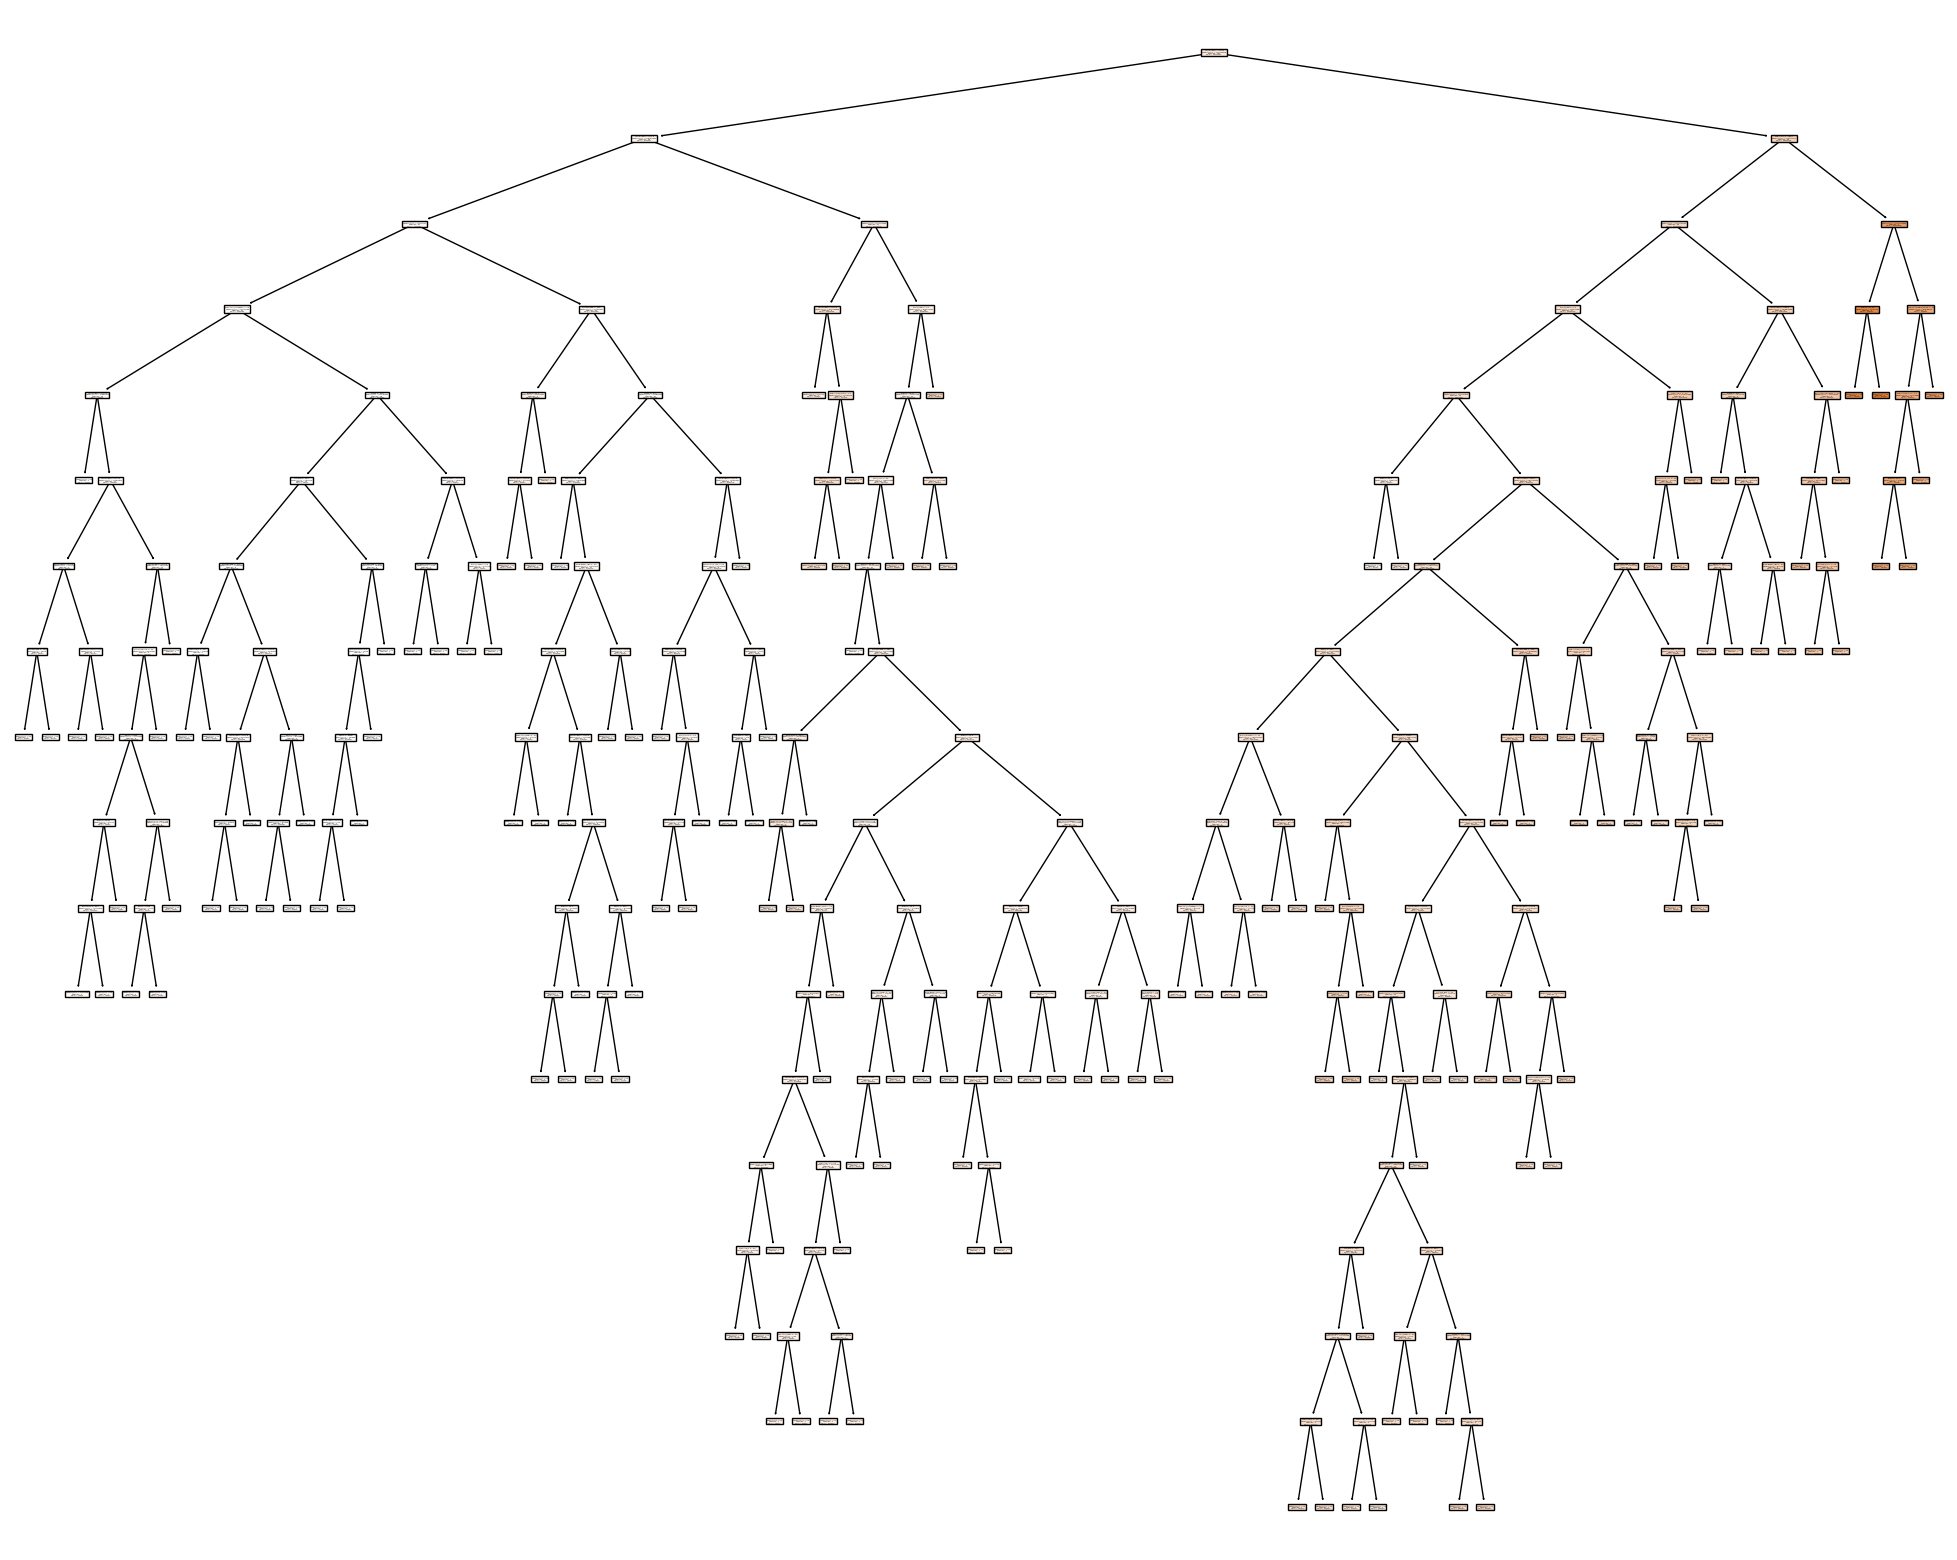

In [35]:
%%time
fig = plt. figure (figsize = (25, 20))
_ = plot_tree(model, feature_names = X_train.columns, class_names = 'LC50', filled=True)

#### Predykcja

In [36]:
y_predict_train = model.predict(X_train)
y_predict_test = model.predict(X_test)

#### Metryki 

In [37]:
R2_train = r2_score(y_true = y_train, y_pred = y_predict_train)
R2_test = r2_score(y_true = y_test, y_pred = y_predict_test)

MAE_train = mean_absolute_error(y_true = y_train, y_pred = y_predict_train)
MAE_test = mean_absolute_error(y_true = y_test, y_pred = y_predict_test)

MSE_train = mean_squared_error(y_true = y_train, y_pred = y_predict_train)
MSE_test = mean_squared_error(y_true = y_test, y_pred = y_predict_test)

RMSE_train = mean_squared_error(y_true = y_train, y_pred = y_predict_train, squared = False)
RMSE_test = mean_squared_error(y_true = y_test, y_pred = y_predict_test, squared = False)

print(f'''R2_train = {R2_train},     R2_test = {R2_test},
MAE_train = {MAE_train},    MAE_test = {MAE_test},
MSE_train = {MSE_train},    MSE_test = {MSE_test},
RMSE_train = {RMSE_train},    RMSE_test = {RMSE_test} ''')

R2_train = 0.9989831862870213,     R2_test = 0.9390522543569019,
MAE_train = 47.6375,    MAE_test = 1856.9634146341464,
MSE_train = 46393.48125,    MSE_test = 7456760.006097561,
RMSE_train = 215.39146048532191,    RMSE_test = 2730.7068693101355 


- R2 jeszcze większe, ale wciąż wyystępuje różnica między zbiorem uczącym i testowym
- MAE, MSE, RMSE - dużo gorsze dla zbioru testowego

**Model przetrenowany**

### Regulacja liczby przypadków w węźle

In [38]:
min_samples_split_list =  [3, 10, 30, 50]
for i in  min_samples_split_list:
    model = DecisionTreeRegressor(random_state = 42, min_samples_split=i)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print(f'minimalna liczba przypadków {i}')
    print(f'R2: {r2_score(y_true = y_train, y_pred = y_pred_train)}  {r2_score(y_true = y_test, y_pred = y_pred_test)}')
    print(f'MRS: {mean_squared_error(y_true = y_train, y_pred = y_pred_train)}   {mean_squared_error(y_true = y_test, y_pred = y_pred_test)}')
  

minimalna liczba przypadków 3
R2: 0.9966253800460196  0.9394499312761942
MRS: 153971.534375   7408105.518292683
minimalna liczba przypadków 10
R2: 0.95152793589161  0.9347792381367381
MRS: 2211602.5469146827   7979549.751964584
minimalna liczba przypadków 30
R2: 0.9378599663153886  0.9329459193341109
MRS: 2835221.880688657   8203850.391497853
minimalna liczba przypadków 50
R2: 0.8723156882490142  0.9213686219878953
MRS: 5825766.94976458   9620295.362826105


Jak widzimy, parametry różnią się od siebie w zależności od liczby przypadków w węźle. 

In [39]:
def train_model(X_train, y_train, X_test, y_test, k):
    model = DecisionTreeRegressor(min_samples_split=k, random_state=42)
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)
    return (r2_train, r2_test)

In [40]:
min_samples_splits = [3, 5, 10, 25, 40, 60, 80, 100]

train_metrics = {}
test_metrics = {}
for min_split_num in min_samples_splits:
    train_score, test_score = train_model(X_train, y_train, X_test, y_test, min_split_num)
    train_metrics[min_split_num] = train_score
    test_metrics[min_split_num] = test_score

In [41]:
train_metrics = pd.Series(train_metrics, name='train')
test_metrics = pd.Series(test_metrics, name='test')

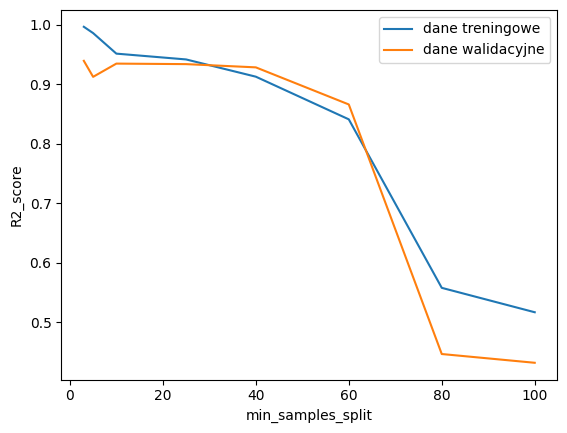

In [42]:
plt.plot(list(train_metrics.index), list(train_metrics), label='dane treningowe')
plt.plot(list(test_metrics.index), list(test_metrics), label='dane walidacyjne')
plt.xlabel('min_samples_split')
plt.ylabel('R2_score')
plt.legend()
plt.show()

Jak widzimy wykres jest najbardziej zbliżony dla wartości od 20 do 60.

In [43]:
model = DecisionTreeRegressor(min_samples_split=50, random_state=22)
model.fit(X_train, y_train)

model.get_n_leaves()

6

CPU times: user 483 ms, sys: 29 ms, total: 512 ms
Wall time: 505 ms


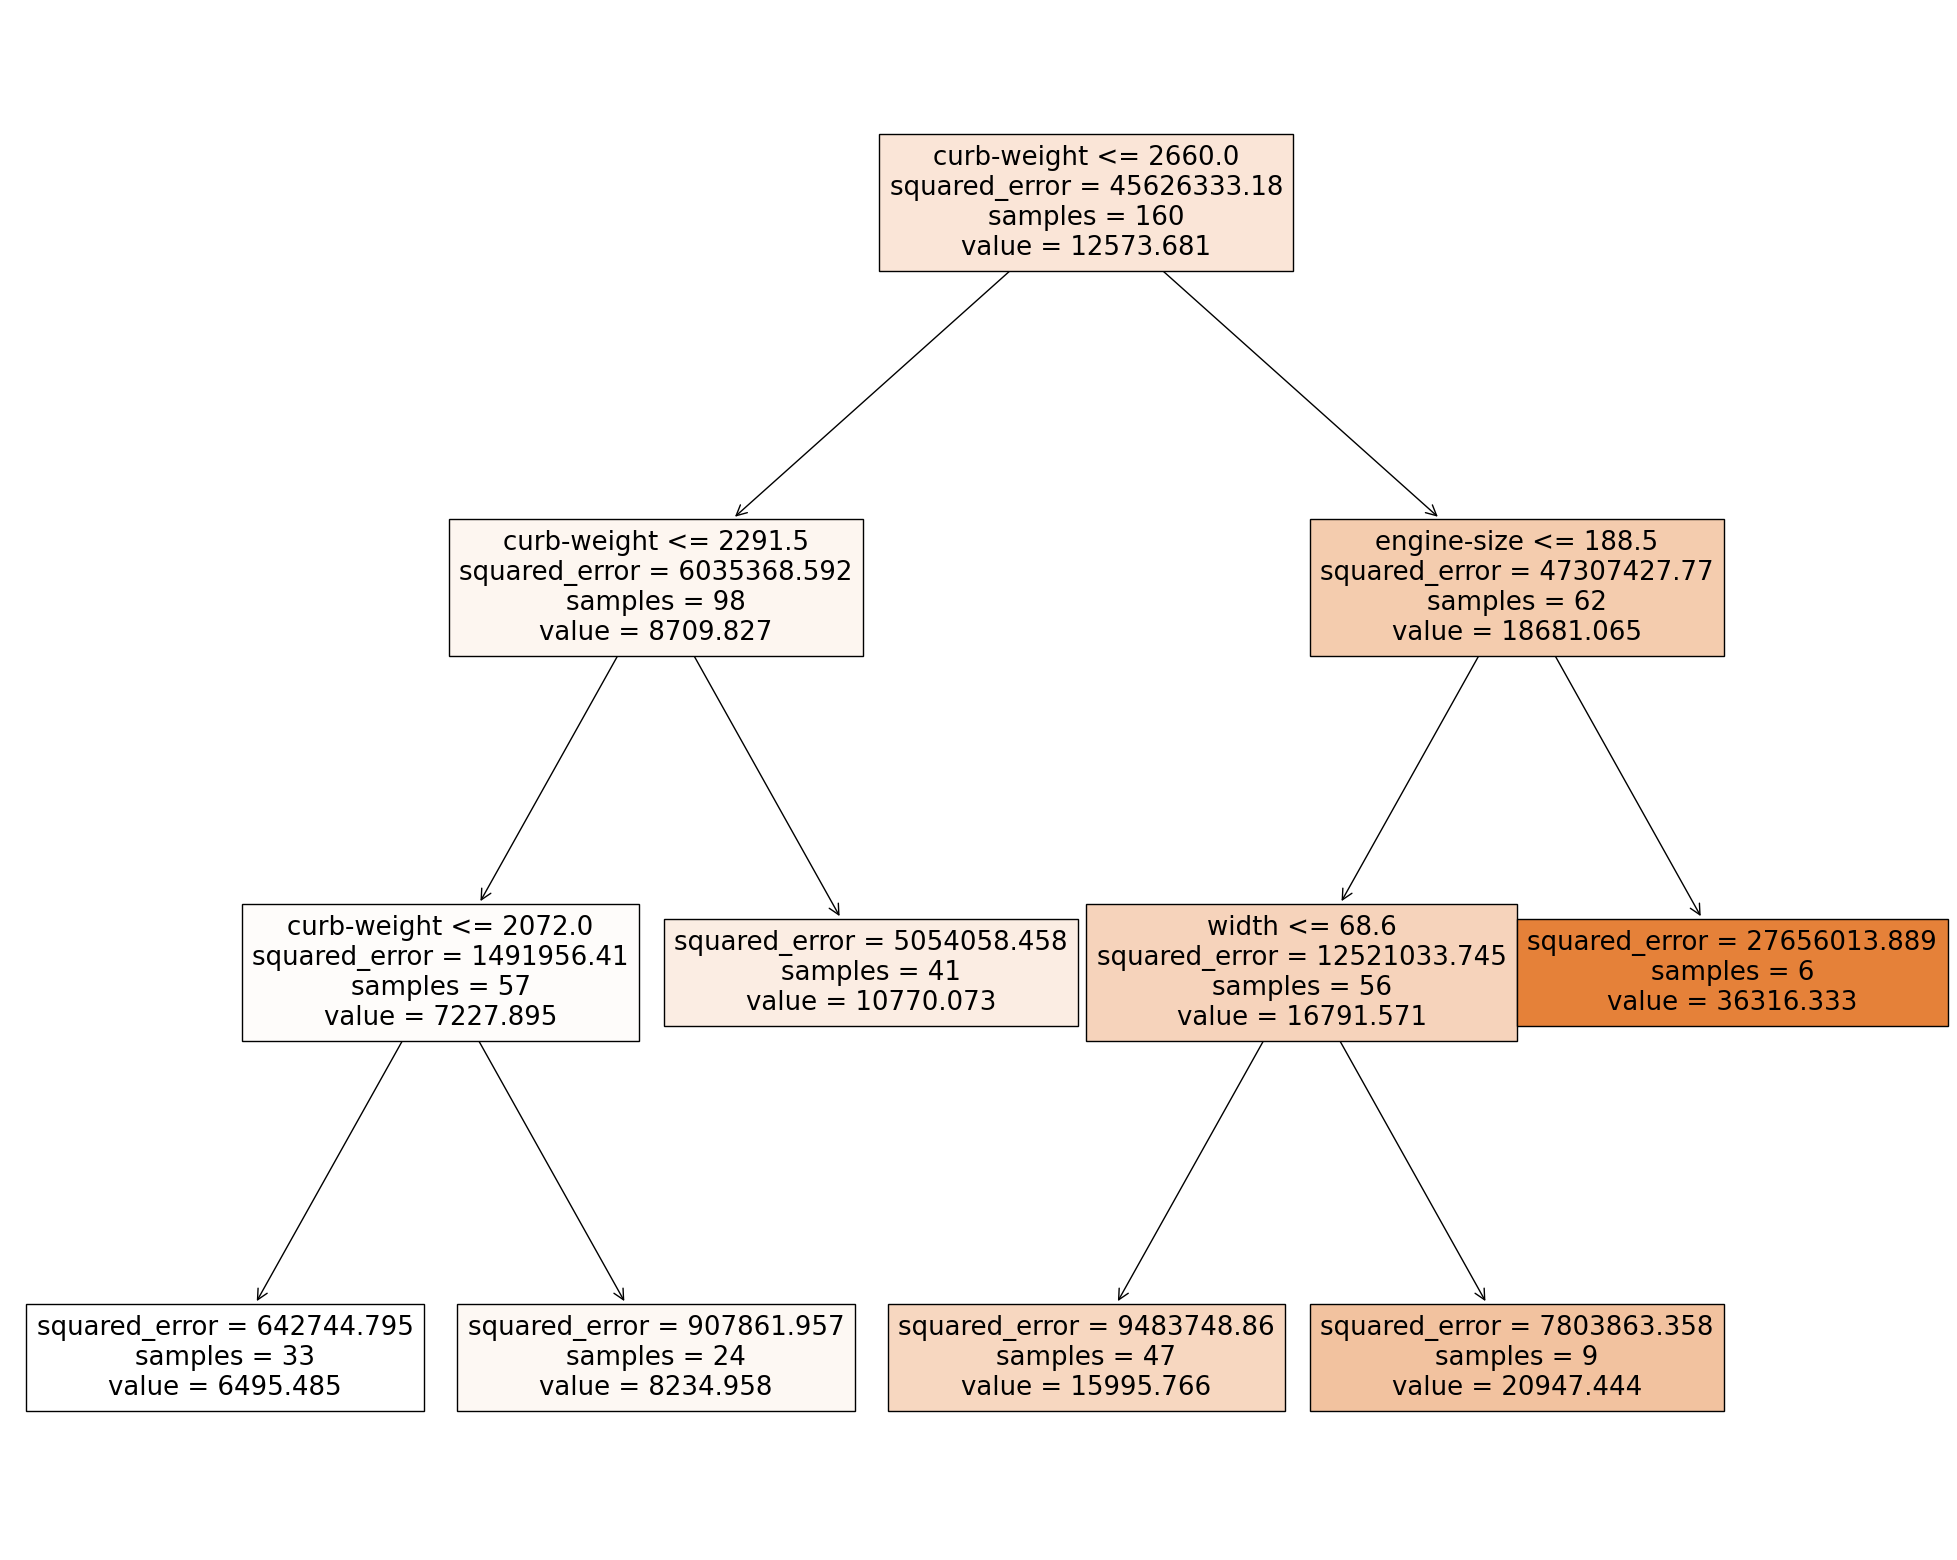

In [44]:
%%time
fig = plt. figure (figsize = (25, 20))
_ = plot_tree(model, feature_names = X_train.columns, class_names = 'price', filled=True)

fig.savefig('decission_tree.png')

In [45]:
model = DecisionTreeRegressor(random_state = 11, min_samples_split=30)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print(f'minimalna liczba przypadków 30')
print(f'R2: {r2_score(y_true = y_train, y_pred = y_pred_train)}  {r2_score(y_true = y_test, y_pred = y_pred_test)}')
print(f'MRS: {mean_squared_error(y_true = y_train, y_pred = y_pred_train)}   {mean_squared_error(y_true = y_test, y_pred = y_pred_test)}')
  

minimalna liczba przypadków 30
R2: 0.9378599663153886  0.9329459193341109
MRS: 2835221.880688657   8203850.391497853
